# Some util functions

## General

In [25]:
def allocate(item, use_cuda=False):
    if use_cuda:
        return item.cuda()
    else:
        return item.cpu()

def split_and_join(sentences: List[str]):
    output = "".join(sentences)
    return list(output)


## Exercise 2

In [18]:
def uppercase_to_num(uppercase_letter: str, vocabulary: List[str]) -> int:
    return vocabulary.index(uppercase_letter)


def num_to_uppercase(number, vocabulary):
    return vocabulary[number]


def sentence_to_num(sentence: str, vocabulary):
    output = []
    for word in sentence:
        output.append(uppercase_to_num(word, vocabulary))
    return torch.Tensor(output).long()


def encrypt_message(plaintext, keyword, vocabulary):
    cyphertext = ""
    for i in range(len(plaintext)):
        p = uppercase_to_num(plaintext[i], vocabulary)
        k = uppercase_to_num(keyword[i], vocabulary)
        c = (p + k) % 26
        cyphertext += num_to_uppercase(c, vocabulary)

    return cyphertext

# Ex.1 - Experimenting with Multi-Class Sequence Classification using RNNs and LSTMs

In [ ]:
'''
Experimenting with Multi-Class Sequence Classification using RNNs and LSTMs
Steps :
1. Load and visualize the training and testing data in 'data/P2_E1.csv' as shown in the following code cell.
2. Following section 2 in the examples, train a RNN or LSTM to solve the multi-class sequence classification problem:
  -   Adapt the classification loss and the SequenceClassifier module
  -   Adapt the test_sequence_classifier function to compute the multi-class accuracy and be able to visualize the confusion matrix
3. Experiment with different models by changing different hyper-parameters (e.g, num_layers, hidden_size, optimiziers, activation_functions for RNNs, etc..) and evaluate  the results for each of them on the testing set.
4. Visualize analyse and discuss the results in the report.
'''

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random
from typing import List

output_path = "Results/"
input_path = "Data/"
seed_value = 10
save_figure = True
use_cuda = False


## Load and visualize the data

Train sequences shape: (210, 40)
Train labels shape: (210,)
Test sequences shape: (90, 40)
Test labels shape: (90,)


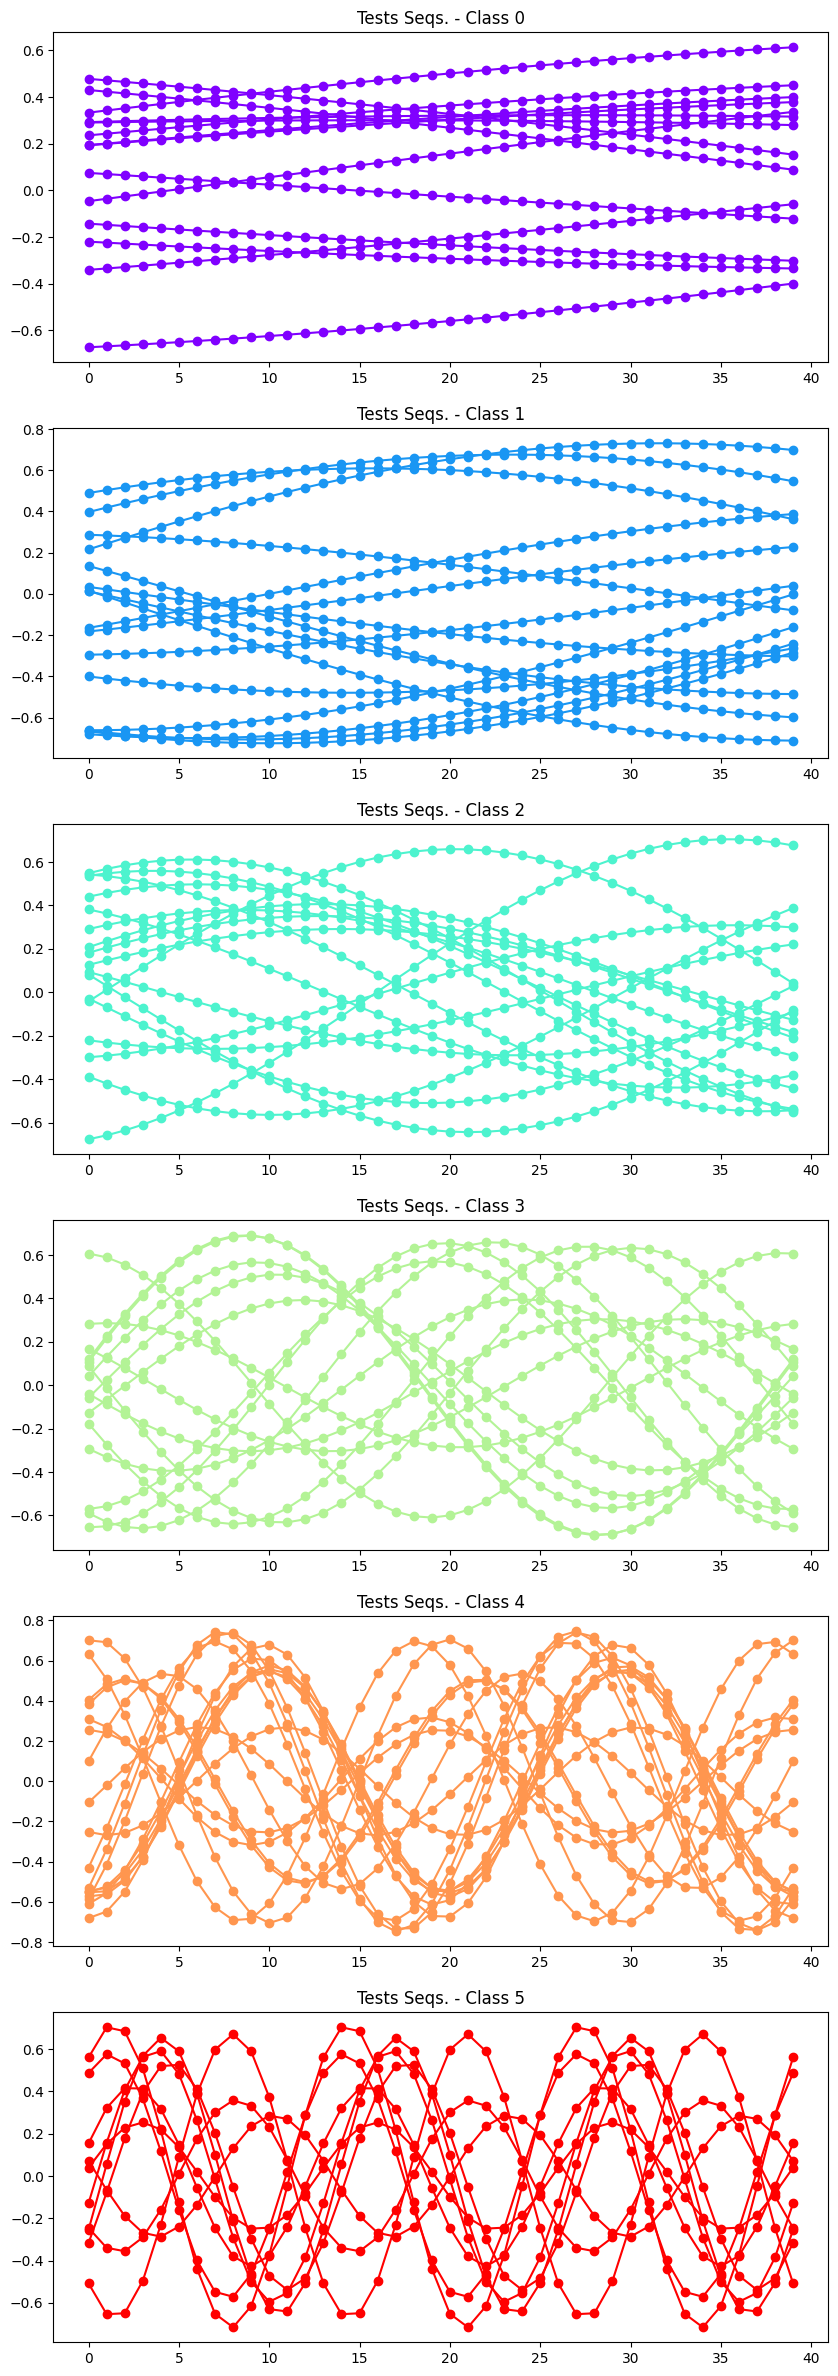

In [8]:
data = np.load(input_path + "P2_E1.npz")
X_train, X_test = data["X_train"], data["X_test"]
Y_train, Y_test = data["Y_train"], data["Y_test"]

print(f"Train sequences shape: {X_train.shape}") # (210, 40) (# sequences, # datapoints per sequence)
print(f"Train labels shape: {Y_train.shape}") # Train Labels: (210,)  (# of sequences, )
print(f"Test sequences shape: {X_test.shape}")
print(f"Test labels shape: {Y_test.shape}")

classes = np.unique(Y_train)
n_classes = len(classes)
colors = plt.cm.rainbow(np.linspace(0, 1, n_classes))

fig1, axs = plt.subplots(n_classes, 1, figsize=(10, 5 * n_classes))
for class_idx in range(0, n_classes):
    axs[class_idx].plot(X_test[Y_test == class_idx, :].T, "-o", c=colors[class_idx])
    axs[class_idx].set_title(f"Tests Seqs. - Class {class_idx}")

if save_figure: plt.savefig(f"{output_path}fig1.png", dpi=300)

plt.show()

## Train a RNN or LSTM to solve the multi-class sequence classification problem.
- Adapt the classification loss and the SequenceClassifier module
- Adapt the test_sequence_classifier function to compute the multi-class accuracy and be able to visualize the confusion matrix

### `SequenceClassifier` class

In [9]:
# Define module encapsulating a Sequence Classifier using RNN or LSTMs and setting different architecture hyper-parameters
class SequenceClassifier(nn.Module):
    def __init__(self, input_size: int = 1, hidden_size: int = 5, num_layers: int = 1, use_lstm: bool = False, bias: bool = False, n_classes: int = 2):
        super().__init__()
        self.use_lstm = use_lstm

        if use_lstm:
            self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, bias=bias)
        else:
            self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, bias=bias)

        self.activation = nn.Softmax(dim=1) # FIXME: Change if necessary
        self.last_linear = nn.Linear(hidden_size, n_classes)

    def forward(self, X):
        _, last_states = self.rnn(X)
        # Get last hidden state for last layer. Ignore cell state in case of LSTMs
        if not self.use_lstm:
            last_hidden_state = last_states[-1, :, :].squeeze(0)
        else:
            last_hidden_state = last_states[0][-1, :, :].squeeze(0)
        # Get sequence label probability using the last hidden state
        output = self.activation(self.last_linear(last_hidden_state))
        return output

### Training and testing functions

In [10]:
def train_sequence_classifier(X_train, Y_train, seq_classifier: SequenceClassifier, optimizer, loss_func, seed_value, epochs=100):
    """
    Given a dataset (with points and target labels), trains a SequenceClassifier.
    """
    torch.manual_seed(seed_value) # Ensures that all trainings use the same random numbers
    loss_its = []
    for iter in range(epochs):
        optimizer.zero_grad()
        output = seq_classifier(X_train)
        loss = loss_func(output, Y_train)
        loss_its.append(loss.item())
        loss.backward()
        optimizer.step()

    print(f"Final loss: {loss.item()}")
    return np.asarray(loss_its)


def test_sequence_classifier(X_test, Y_test, seq_classifier):
    """
    Given a dataset (with points and target labels), computes the accuracy of the model.
    """
    output = seq_classifier(X_test)
    classification = torch.argmax(output, dim=1)
    conf_matrix = confusion_matrix(y_true=Y_test, y_pred=classification, normalize=None)
    accuracy = (torch.sum(classification == Y_test) / output.shape[0]).item()

    print(f"Test Accuracy: {np.round(accuracy * 100, decimals=3)} %")
    return accuracy, conf_matrix


## Experiment with different models by changing different hyper-parameters
(e.g, num_layers, hidden_size, optimiziers, activation_functions for RNNs, etc..) and evaluate  the results for each of them on the testing set.

In [12]:
# Dataset to PyTorch format
X_train_pt = allocate( torch.from_numpy(X_train).float().unsqueeze(2), use_cuda )
Y_train_pt = allocate( torch.from_numpy(Y_train).long(), use_cuda )
X_test_pt = allocate( torch.from_numpy(X_test).float().unsqueeze(2), use_cuda )
Y_test_pt = allocate( torch.from_numpy(Y_test).long(), use_cuda )

print('\nX_train and Y_train shape after being moved to torch:')
print(X_train_pt.shape) # (210, 40, 1)
print(Y_train_pt.shape) # (210,)
print('-------------------------------')


X_train and Y_train shape after being moved to torch:
torch.Size([210, 40, 1])
torch.Size([210])
-------------------------------



Training: H5_NL3_LSTM1
Final loss: 1.792034387588501
Test Accuracy: 25.556 %

Training: H5_NL10_LSTM1
Final loss: 1.7923760414123535
Test Accuracy: 20.0 %

Training: H20_NL3_LSTM1
Final loss: 1.7400943040847778
Test Accuracy: 26.667 %

Training: H20_NL10_LSTM1
Final loss: 1.7908679246902466
Test Accuracy: 15.556 %

Training: H100_NL3_LSTM1
Final loss: 1.5347198247909546
Test Accuracy: 54.444 %

Training: H100_NL10_LSTM1
Final loss: 1.7590001821517944
Test Accuracy: 21.111 %


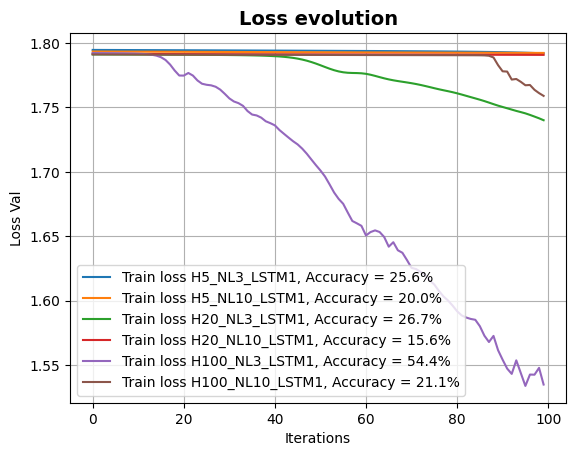

In [13]:
# Define Cross Entropy Loss
loss_func = nn.CrossEntropyLoss()

# Hyperparameters
input_size = 1  # number of features of each point
hidden_sizes_list = [5, 5, 20, 20, 100, 100]
num_layers_list = [3, 10] * 3
use_lstm_list = [True] * 6
bias = False
optimizer_class = torch.optim.Adam
lr = 1e-3
epochs = 100

# Train the models
losses_models = {}
test_accuracy_models = {}
confusion_matrix_models = {}

for hidden_size, num_layers, use_lstm in zip(hidden_sizes_list, num_layers_list, use_lstm_list):
    model_id = f"H{hidden_size}_NL{num_layers}_LSTM{int(use_lstm)}"
    print(f"\nTraining: {model_id}")

    seq_classifier = SequenceClassifier(input_size, hidden_size, num_layers, use_lstm, bias, n_classes)
    allocate(seq_classifier, use_cuda)
    optimizer = optimizer_class(seq_classifier.parameters(), lr=lr)

    losses_models[model_id] = train_sequence_classifier(X_train_pt, Y_train_pt, seq_classifier, optimizer, loss_func, seed_value, epochs)
    test_accuracy_models[model_id], confusion_matrix_models[model_id] = test_sequence_classifier(X_test_pt, Y_test_pt, seq_classifier)

# Visualize loss function evolution
fig2 = plt.figure(2)
for model, loss in losses_models.items():
    accuracy = np.round(test_accuracy_models[model] * 100, decimals=1)
    plt.plot(loss, label=f"Train loss {model}, Accuracy = {accuracy}%")

plt.title(f'Loss evolution', fontsize=14, fontweight="bold")
plt.xlabel('Iterations')
plt.ylabel('Loss Val')
# plt.ylim(0, None)
plt.grid()
plt.legend()

if save_figure: plt.savefig(f"{output_path}fig2.png", dpi=300)

plt.show()

### Visualize the confusion matrix

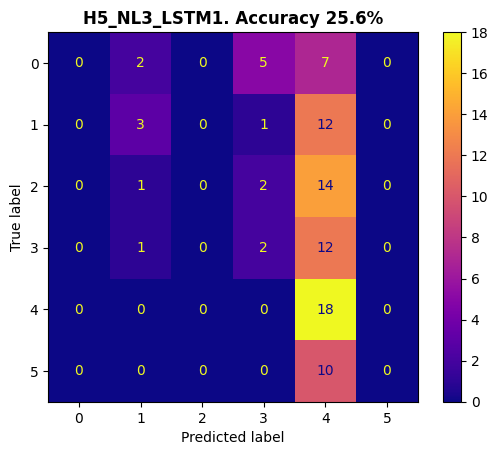

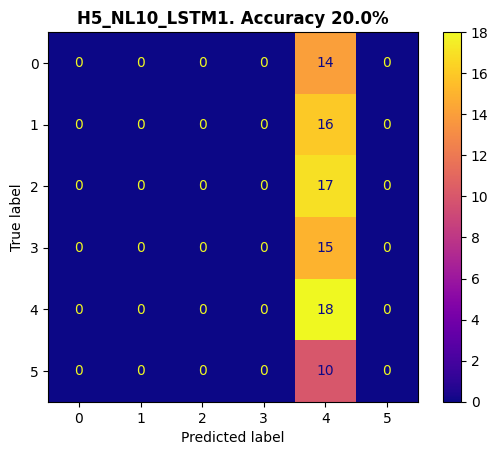

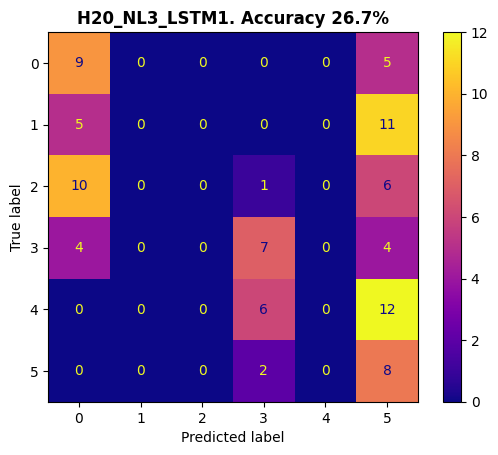

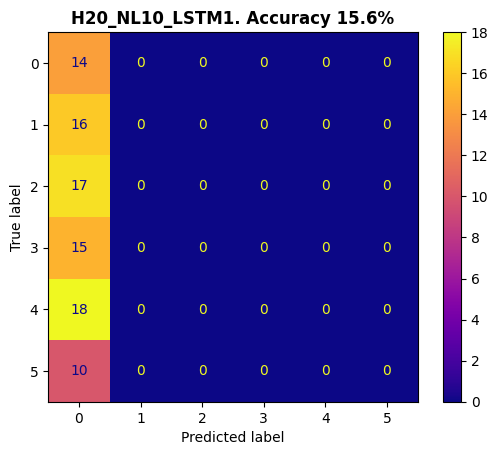

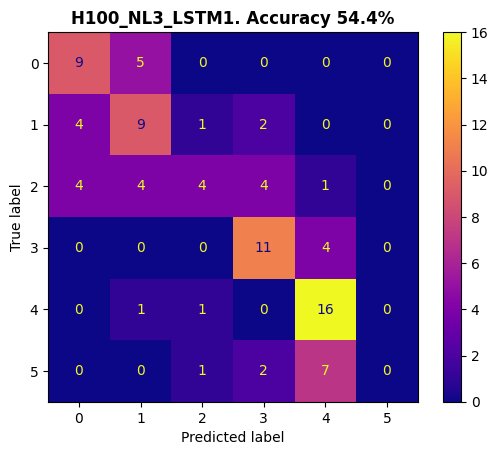

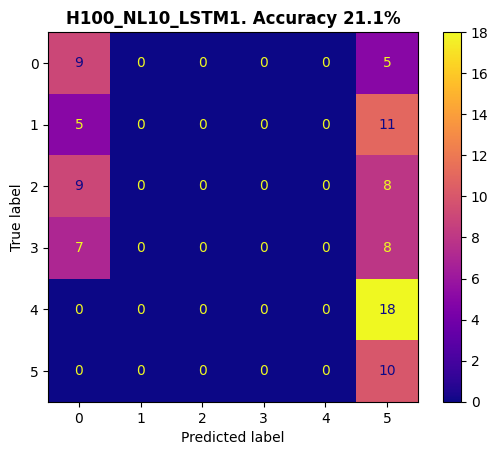

In [15]:
# TODO: make a composition of all the matrices into a same plot, or automate the process of saving all the images.
# Visualize the confusion matrices
for model, cm in confusion_matrix_models.items():
    accuracy = np.round(test_accuracy_models[model] * 100, decimals=1)
    fig = ConfusionMatrixDisplay(cm).plot(cmap="plasma")
    fig.ax_.set_title(f"{model}. Accuracy {accuracy}%", fontweight="bold")

plt.show()

# Ex 2. Cryptoanalysis with corrupted messages using RNNs/LSTMs

In [ ]:
'''
Similar to the exercise solved on P2-examples, you have to solve time-series modelling based on Cryptanalysis. 

For this exercise, you have training.pkl and testing_corrupted.pkl files. 
These files contain a new encrypted dataset of 10000 sentences, 8000 for training and 2000 for the test. 
Similar to the exercise solved in class, all the samples are encrypted using the Vigenère cipher with 
7-length keyword. However, during the transmission of the test set, the encrypted data has been corrupted 
with a new char ("-"), while the training set has been transmitted correctly. 

Each 32-length sentence contains 4 corrupted chars randomly distributed on the test set, representing 12,5 % of total data.

Example:

Received Ciphertext:   'WCPS-VH-JHIKCUSETJV-AW-LPVUAHFHH'
Correct Ciphertext (Not provided):   'WCPSEVHAJHIKCUSETJVKAWGLPVUAHFHH'
Ground truth:   'HEWENTALLOUTANDGAVEITHISBESTSHOT'

Steps : 
1. Discover the keyword used to encrypt the plaintext data. (hint: use Vigenère table and some samples) manually?
2. Analyze the data distribution and define the new alphabet. Do plots (histogram)
3. Design/Implement an strategy to train the model so that it can be robust to missing characters in the testing samples ( to be discussed in class )
4. Train a sequential model to decode the corrupted test data. 
5. Evaluate the decoding accuracy for the test set in terms of characters that were not corrupted or corrupted independently.
6. Try to improve the performance by applying some improvements over the model: stacked LSTMs, 
hidden_sizes, embedding_size, optimizer, data augmentation during training, etc...
7. Visualize and discuss on the final results.
'''

'\nSimilar to the exercise solved on P2-examples, you have to solve time-series modelling based on Cryptanalysis. \n\nFor this exercise, you have training.pkl and testing_corrupted.pkl files. \nThese files contain a new encrypted dataset of 10000 sentences, 8000 for training and 2000 for the test. \nSimilar to the exercise solved in class, all the samples are encrypted using the Vigenère cipher with \n7-length keyword. However, during the transmission of the test set, the encrypted data has been corrupted \nwith a new char ("-"), while the training set has been transmitted correctly. \n\nEach 32-length sentence contains 4 corrupted chars randomly distributed on the test set, representing 12,5 % of total data.\n\nExample:\n\nReceived Ciphertext:   \'WCPS-VH-JHIKCUSETJV-AW-LPVUAHFHH\'\nCorrect Ciphertext (Not provided):   \'WCPSEVHAJHIKCUSETJVKAWGLPVUAHFHH\'\nGround truth:   \'HEWENTALLOUTANDGAVEITHISBESTSHOT\'\n\nSteps : \n1. Discover the keyword used to encrypt the plaintext data. (hin

## Discover the keyword used to encrypt the plaintext data.
Hint: use Vigenère table and some samples

In [17]:
import pickle

with open(input_path + "training.pkl", "rb") as pkl_file:
    train = pickle.load(pkl_file)

with open(input_path + "testing_corrupted.pkl", "rb") as pkl_file:
    test = pickle.load(pkl_file)
vocabulary = [char for char in "ABCDEFGHIJKLMNOPQRSTUVWXYZ-"]  # Predefined vocabulary

with open(input_path + "our_training.pkl", "rb") as pkl_file:
    our_train = pickle.load(pkl_file)

vocabulary = [char for char in "ABCDEFGHIJKLMNOPQRSTUVWXYZ-"]  # Predefined vocabulary


print(f'Our training dataset has {len(our_train)} sentences')

Our training dataset has 63516 sentences


In [19]:
def decode_message(message, vocabulary):
    decoded = ""
    for letter_code in message:
        decoded += vocabulary[letter_code]
    return decoded


decoded_train_cypher = [decode_message(pair[0], vocabulary) for pair in train]
decoded_train_plaintext = [decode_message(pair[1], vocabulary) for pair in train]
decoded_test_cypher = [decode_message(pair[0], vocabulary) for pair in test]
decoded_test_plaintext = [decode_message(pair[1], vocabulary) for pair in test]

### Discover the keyword

In [22]:
def find_vigenere_keyword(plaintext, ciphertext, vocabulary):
    plaintext = plaintext.upper()
    ciphertext = ciphertext.upper()

    keyword = ""
    for i in range(len(plaintext)):
        p = uppercase_to_num(plaintext[i], vocabulary)  # Convert plaintext character to a numeric value (0-25)
        c = uppercase_to_num(ciphertext[i], vocabulary)  # Convert ciphertext character to a numeric value (0-25)
        k = (c - p) % 26  # Calculate the shift between the plaintext and ciphertext characters
        keyword += num_to_uppercase(k, vocabulary)  # Convert the shift value back to a character and append it to the keyword

    return keyword


encrypted1 = decode_message(train[0][0], vocabulary)
decrypted1 = decode_message(train[0][1], vocabulary)

keyword = find_vigenere_keyword(decrypted1, encrypted1, vocabulary)

print(f"The keyword used is: {keyword}\n")

The keyword used is: PYTORCHPYTORCHPYTORCHPYTORCHPYTO



### Verify that the found keyword is the one expected

In [23]:
test_keyword = 3
for i in range(test_keyword):
    print("==================================================")
    print(f"Plaintext: {decode_message(train[i][1], vocabulary)}")
    our_encrypted = encrypt_message(decode_message(train[i][1], vocabulary), keyword, vocabulary)
    print(f"Encrypted plaintext: {our_encrypted}")
    print(f"Our encryption == encrypted message from dataset {our_encrypted == decode_message(train[i][0], vocabulary)}")
    print("==================================================\n")


Plaintext: ILLCALLTHEMTOMORROWWHENICOMEBACK
Encrypted plaintext: XJEQRNSIFXAKQTDPKCNYOTLBQFOLQYVY
Our encryption == encrypted message from dataset True

Plaintext: IDBEUNHAPPYBUTIWOULDNTKILLMYSELF
Encrypted plaintext: XBUSLPOPNIMSWAXUHICFUIIBZCOFHCET
Our encryption == encrypted message from dataset True

Plaintext: ITHOUGHTYOULIKEDTOLEARNNEWTHINGS
Encrypted plaintext: XRACLIOIWHICKRTBMCCGHGLGSNVOXLZG
Our encryption == encrypted message from dataset True



## Analyze the data distribution and define the new alphabet

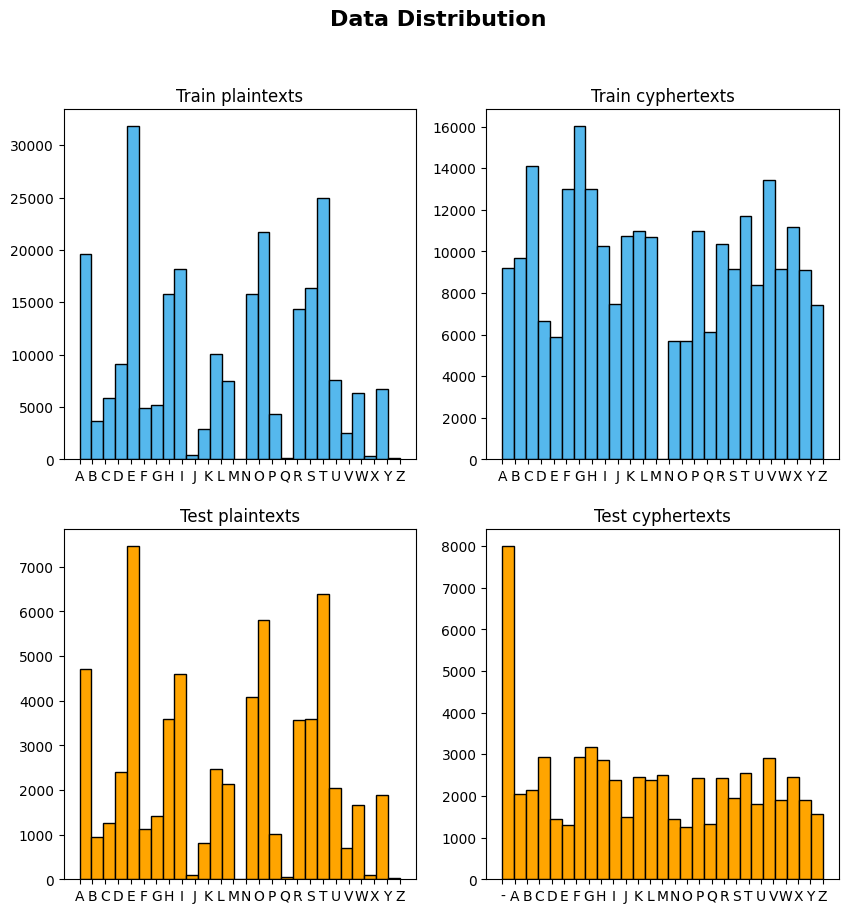

In [26]:
train_cypher_chars = split_and_join(decoded_train_cypher)
train_cypher_chars = sorted(train_cypher_chars)

train_plaintext_chars = split_and_join(decoded_train_plaintext)
train_plaintext_chars = sorted(train_plaintext_chars)

test_cypher_chars = split_and_join(decoded_test_cypher)
test_cypher_chars = sorted(test_cypher_chars)

test_plaintext_chars = split_and_join(decoded_test_plaintext)
test_plaintext_chars = sorted(test_plaintext_chars)

bins = len(vocabulary)

fig3, axs = plt.subplots(2, 2, figsize=(10, 10))
fig3.suptitle("Data Distribution", fontsize="16", fontweight="bold")
axs[0, 0].hist(train_plaintext_chars, bins, color="#55b8ed", edgecolor="black")
axs[0, 0].set_title("Train plaintexts")
axs[0, 1].hist(train_cypher_chars, bins, color="#55b8ed", edgecolor="black")
axs[0, 1].set_title("Train cyphertexts")
axs[1, 0].hist(test_plaintext_chars, bins, color="orange", edgecolor="black")
axs[1, 0].set_title("Test plaintexts")
axs[1, 1].hist(test_cypher_chars, bins, color="orange", edgecolor="black")
axs[1, 1].set_title("Test cyphertexts")

if save_figure: plt.savefig(f"{output_path}/fig3.png", dpi=300)
plt.show()

## Design/Implement an strategy to train the model so that it can be robust to missing characters in the testing samples

In [27]:
class DecrypterNetwork(nn.Module):
    def __init__( self, hidden_size: int = 8, num_layers=1, num_letters=26, letters_embedding_size: int = 8, use_lstm: bool = False):
        # Define RNN or LSTM architecture
        super().__init__()
        self.hidden_size = hidden_size
        self.num_letters = num_letters
        self.letters_embedder = torch.nn.Embedding(num_letters, letters_embedding_size)
        self.use_lstm = use_lstm
        self.softmax = nn.Softmax(dim=1)
        if use_lstm:
            self.rnn = nn.LSTM( input_size=letters_embedding_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        else:
            self.rnn = nn.RNN( input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.last_linear = nn.Linear(hidden_size, num_letters)

    def forward(self, X):
        N = X.shape[0]
        L = X.shape[1]

        embedded_letters = self.letters_embedder(X)
        
        # Get hidden states for all letters in the sequence
        hidden_states, _ = self.rnn(embedded_letters)
        
        # In case of multiple input sequneces flat (N,L,hidden_size) to (N*L,hidden_size) for linear layer
        hidden_states_concat = hidden_states.reshape(-1, self.hidden_size)
        
        # Get letters probability using the hidden states for each position in the sequence
        letters_loggits = self.last_linear(hidden_states_concat)
        
        # Use soft-max over logits and reshape to format (N,L,num_letteres)
        letters_probs = self.softmax(letters_loggits).reshape(N, L, self.num_letters)
        
        return letters_probs


### Functions to corrupt our dataset

In [28]:
def corrupt_sentence(sentence: str, corruption_ratio: float = 0.125) -> str:
    num_hyphens = int(len(sentence) * corruption_ratio)
    numbers = random.sample(range(32), num_hyphens)

    sentence_as_list = list(sentence)
    for n in numbers:
        sentence_as_list[n] = "-"

    return "".join(sentence_as_list)


def corrupt_data(input_list: List[str], corruption_ratio: float = 0.125):
    output_list = []
    for sentence in input_list:
        output_list.append(corrupt_sentence(sentence, corruption_ratio))
    return output_list

### Corrupt our dataset

In [29]:
corrupted_train_cypher = []
our_train_cypher = [encrypt_message(sentence, keyword, vocabulary) for sentence in our_train]
ratios = [0.05, 0.125, 0.25]
splitted = np.array_split(our_train_cypher, len(ratios))
for idx, ratio in enumerate(ratios):
    corrupted_train_cypher += corrupt_data(splitted[idx], corruption_ratio=ratio)

corrupted_train = [[sentence_to_num(cypher, vocabulary), sentence_to_num(plaintext, vocabulary)] for cypher, plaintext in zip(corrupted_train_cypher, our_train)]

In [30]:
def train_test( model, num_epochs, loss_fn, optimizer, train_encrypted, train_decrypted, test_encrypted, test_decrypted, vocabulary, use_cuda=False):
    model = allocate(model, use_cuda)
    train_encrypted = allocate(train_encrypted, use_cuda)
    train_decrypted = allocate(train_decrypted, use_cuda)
    test_encrypted = allocate(test_encrypted, use_cuda)
    test_decrypted = allocate(test_decrypted, use_cuda)
				
    accuracies, max_accuracy = [], 0
    loss_hist = []
    acc_hist = []
    epochs_hist = []
    test_loss_hist = []

    for epoch in range(num_epochs):
        # TRAINING AND BACK-PROPAGATION
        optimizer.zero_grad()
        letters_probs = model(train_encrypted)
        loss = loss_fn(letters_probs.log().permute(0, 2, 1), train_decrypted) # rearrange as to (N_sequences, N_letters, N_lenght_sequences)
        loss.backward()  # Backpropagate
        optimizer.step()  # Update weights
        loss_hist.append(loss.item())

        # EVALUATION
        letters_probs = model(test_encrypted)
        test_loss = loss_fn(letters_probs.log().permute(0, 2, 1), test_decrypted)  # rearrange as to (N_sequences, N_letters, N_lenght_sequences)
        _, maxprob_letters_idx = letters_probs.max(dim=2)  # get letter with maximum prob
        accuracy = ((maxprob_letters_idx == test_decrypted) * 1.0).mean()  # compute accuracy
        test_loss_hist.append(test_loss.item())
        acc_hist.append(accuracy.item())

        print(f"Epoch {epoch} \t Train Loss {round(loss.item(),3)} \t Test Loss {round(test_loss.item(),3)} \t Test Acc. (%)  {round(accuracy.item()*100,1)}") # TODO : Remove
        
        if epoch % 50 == 0:
            print(f"Epoch {epoch} \t Train Loss {round(loss.item(),3)} \t Test Loss {round(test_loss.item(),3)} \t Test Acc. (%)  {round(accuracy.item()*100,1)}")
    
    print(f"Final Epoch \t Train Loss {round(loss.item(),3)} \t Test Loss {round(test_loss.item(),3)} \t Test Acc. (%)  {round(accuracy.item()*100,1)}")
    
    return model, loss_hist, test_loss_hist, acc_hist

In [31]:
# Converting training and testing datasets into PyTorch Tensor (N_seqs, lenght_seqs)
print('Type of corrupted_train:', type(corrupted_train), 'Length of corrupted train:', len(corrupted_train)) # FIXME: Remove this

train_encrypted = torch.concat([train_sample[0].unsqueeze(0) for train_sample in corrupted_train], dim=0)
train_decrypted = torch.concat([train_sample[1].unsqueeze(0) for train_sample in corrupted_train], dim=0)
test_encrypted = torch.concat([test_sample[0].unsqueeze(0) for test_sample in test], dim=0)
test_decrypted = torch.concat([test_sample[1].unsqueeze(0) for test_sample in test], dim=0)

# Initialize  Decrypter Network
letters_embedding_size = 4
hidden_size = 16
num_letters = len(vocabulary)
num_layers = 2
use_lstm = True


decrypter_network = DecrypterNetwork(
    letters_embedding_size=letters_embedding_size,
    num_layers=num_layers,
    num_letters=num_letters,
    hidden_size=hidden_size,
    use_lstm=use_lstm,
)

# Define loss, optimizer and run training/evaluation loop
num_epochs = 1000
CE_loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(decrypter_network.parameters(), lr=0.05)

decrypter_network, loss_hist, test_loss_hist, acc_hist = train_test(decrypter_network, num_epochs, CE_loss, optimizer,
                                                                    train_encrypted, train_decrypted, test_encrypted, test_decrypted,
                                                                    vocabulary, use_cuda=False)

Type of corrupted_train: <class 'list'> Length of corrupted train: 63516
Epoch 0 	 Train Loss 3.327 	 Test Loss 3.207 	 Test Acc. (%)  8.9
Epoch 0 	 Train Loss 3.327 	 Test Loss 3.207 	 Test Acc. (%)  8.9
Epoch 1 	 Train Loss 3.195 	 Test Loss 3.076 	 Test Acc. (%)  6.5
Epoch 2 	 Train Loss 3.035 	 Test Loss 3.047 	 Test Acc. (%)  11.4
Epoch 3 	 Train Loss 2.976 	 Test Loss 3.013 	 Test Acc. (%)  12.5
Epoch 4 	 Train Loss 2.935 	 Test Loss 3.002 	 Test Acc. (%)  12.5
Epoch 5 	 Train Loss 2.925 	 Test Loss 2.994 	 Test Acc. (%)  12.5
Epoch 6 	 Train Loss 2.92 	 Test Loss 2.983 	 Test Acc. (%)  12.4
Epoch 7 	 Train Loss 2.913 	 Test Loss 2.974 	 Test Acc. (%)  12.5
Epoch 8 	 Train Loss 2.906 	 Test Loss 2.968 	 Test Acc. (%)  11.8
Epoch 9 	 Train Loss 2.901 	 Test Loss 2.963 	 Test Acc. (%)  11.8
Epoch 10 	 Train Loss 2.898 	 Test Loss 2.958 	 Test Acc. (%)  11.8
Epoch 11 	 Train Loss 2.895 	 Test Loss 2.953 	 Test Acc. (%)  11.8
Epoch 12 	 Train Loss 2.894 	 Test Loss 2.948 	 Test Acc. 

KeyboardInterrupt: 

In [ ]:
plt.plot(loss_hist, "-.r", linewidth=1.0, label="train_loss")
plt.plot(test_loss_hist, "-b", linewidth=1.0, label="test_loss")
plt.xlabel("train step", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.legend()
plt.show()

plt.plot(acc_hist, linewidth=3.0, label="test_acc")
plt.xlabel("train step", fontsize=14)
plt.ylabel("accuracy(%)", fontsize=14)
plt.ylim([0, 1])
plt.xlim([0, num_epochs])
plt.legend()
plt.show()

In [32]:
decrypter_network = decrypter_network.cpu()
for idx_sample in range(0, 3):
    # Inference over single training sequence
    letters_probs = decrypter_network(test[idx_sample][0].unsqueeze(0))
    # get index of letter with max probability
    _, maxprob_letters_idx = letters_probs.max(dim=2)
    print("--------------------------------------")
    print(f"Original Message encrypted: {decode_message(test[idx_sample][0],vocabulary)}")
    print(f"Message decrypted: {decode_message(test[idx_sample][1],vocabulary)}")
    print(f"Prediction Message decrypted: {decode_message(maxprob_letters_idx[0],vocabulary)}")
    acc = (1.0 * (maxprob_letters_idx[0] == test[idx_sample][1])).mean().item()
    print(f"Prediction Message Accuracy : {round(acc,2)}")


--------------------------------------
Original Message encrypted: WCPSEVHAJ----USETJVKAWGLPVUAHFHH
Message decrypted: HEWENTALLOUTANDGAVEITHISBESTSHOT
Prediction Message decrypted: TEEEHEEHEEEEEEETETEEHHEEEEEHEHEE
Prediction Message Accuracy : 0.19
--------------------------------------
Original Message encrypted: BYKMJYH-RASFPS-NACEGUJK-SIVVB-TR
Message decrypted: MARYSWASTHEONLYPHONENUMBERTOMHAD
Prediction Message decrypted: ETEETHEETHEHEEEHHEHEETEEEHEEEEET
Prediction Message Accuracy : 0.19
--------------------------------------
Original Message encrypted: -CXLGNH-LX-KQO-PAWJEPGANAJVHCAXG
Message decrypted: HEEXPLAINEDTOHERHISCIRCUMSTANCES
Prediction Message decrypted: EEEEEHEEEEEEEHEEHHTHEEHHHTEEEHEE
Prediction Message Accuracy : 0.22
